In [2]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
# Função que carrega os dados
def load_data_with_pairs(folder, csv_file_path, csv_pairs_path, type):
    if not os.path.exists(folder):
        print(f"A pasta {folder} não existe.")
        return [], [], [], [], [], [], [], []

    # Abre o arquivo .csv com os dados e o arquivo com os pares (original e contra-lateral)
    df = pd.read_csv(csv_file_path)
    df_pairs = pd.read_csv(csv_pairs_path)

    patient_ids = []

    images_by_group = {}
    labels_by_group = {}

    ignored_patients = ['sub-02A13', 'sub-03C08']

    current_patient_id = None
    for _, row in df.iterrows():
        patient_id = row['Nome_P']
        patch_id = row['numeracao']
        label = int(row['label'])

        if patient_id in ignored_patients:
            continue
        
        if patient_id != current_patient_id:
            current_patient_id = patient_id
            labels_by_group[patient_id] = {}

        labels_by_group[patient_id][patch_id] = label

    for _, row in tqdm(df.iterrows(), desc="Carregamento de arquivos NIfTI..."):
        patient_id = row['Nome_P']
        patch_id = row['numeracao']

        if patient_id in ignored_patients:
            continue
        
        if patient_id not in images_by_group:
            images_by_group[patient_id] = {}
        
        image_file = f'{patient_id}_{patch_id}_recorte_{type}.nii.gz'
        try:
            img_path = os.path.join(folder, image_file)
            image_data = nib.load(img_path).get_fdata()
            image_data = np.expand_dims(image_data, axis=-1)  # Expandir a dimensão do canal
            images_by_group[patient_id][patch_id] = image_data  # Armazenar a imagem no dicionário

        except Exception as e:
            print(f"Erro ao carregar {image_file}: {e}")
            continue

    images_original = {}
    images_opposite = {}
    labels_pair = {}
    
    for _, row in df_pairs.iterrows():
        original_patch_id = row['patch_identificacao']
        opposite_patch_id = row['patch_oposto']
        patient_id = row['Nome_P']
        
        if patient_id in images_by_group:
            if patient_id not in images_original:
                images_original[patient_id] = {}
            if patient_id not in images_opposite:
                images_opposite[patient_id] = {}
            if patient_id not in labels_pair.keys():
                labels_pair[patient_id] = []
            inseriu = False
            
            if original_patch_id in images_by_group[patient_id].keys() and original_patch_id not in images_opposite[patient_id].keys():
                images_original[patient_id][original_patch_id] = images_by_group[patient_id][original_patch_id]
                inseriu = True
                
            if opposite_patch_id in images_by_group[patient_id].keys() and opposite_patch_id not in images_original[patient_id].keys():
                images_opposite[patient_id][opposite_patch_id] = images_by_group[patient_id][opposite_patch_id]
                inseriu = True
            
            if inseriu:    
                if labels_by_group[patient_id][original_patch_id] != labels_by_group[patient_id][opposite_patch_id]:
                    labels_pair[patient_id].append(1)
                else:
                    labels_pair[patient_id].append(0)
            
            patient_ids.append(patient_id)
            
    # Verificar as formas finais
    unique_patients = set(patient_ids)
    patients_to_remove = [patient_id for patient_id in images_by_group if patient_id not in unique_patients]
    for patient_id in patients_to_remove:
        del images_by_group[patient_id]
        
    print(f"Total de pacientes: {len(unique_patients)}")
    for patient_id, images in images_by_group.items():
        print(f"Paciente {patient_id}: Total de recortes: {len(images)}")
    
    return images_original, images_opposite, labels_pair

In [4]:
# Função para aumentar as imagens da classe minoritária
def augment_data(images, images_opposite, labels, augment_factor):
    datagen = ImageDataGenerator(
        rotation_range=20,  # Rotação aleatória até 20 graus
        width_shift_range=0.2,  # Deslocamento horizontal aleatório até 20% da largura
        height_shift_range=0.2,  # Deslocamento vertical aleatório até 20% da altura
        fill_mode='nearest'  # Preencher os pixels faltantes com o valor mais próximo
    )

    augmented_images = []
    augmented_images_opposite = []
    augmented_labels = []

    for img, img_opposite, label in zip(images, images_opposite, labels):
        img = np.expand_dims(img, axis=0)
        augment_iter = datagen.flow(img, batch_size=1)
        img_opposite = np.expand_dims(img_opposite, axis=0)
        augment_iter_opposite = datagen.flow(img, batch_size=1)
        
        # Gerar mais imagens de augmentação
        for _ in range(augment_factor):
            augmented_img = next(augment_iter)[0]
            augmented_img_opposite = next(augment_iter_opposite)[0]
            augmented_images.append(augmented_img)
            augmented_images_opposite.append(augmented_img_opposite)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_images_opposite), np.array(augmented_labels)


In [5]:
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = []
    selected_images_opposite = []
    selected_labels = []
    
    for patient in patients:
        # Verificar se o paciente existe em all_images_original e all_images_opposite antes de acessar
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original.extend(all_images_original[patient])
            selected_images_opposite.extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return np.array(selected_images_original), np.array(selected_images_opposite), np.array(selected_labels)

In [6]:
# Função para preparar os dados para treino, validação e teste
def prepare_data_for_training_balanced(images_original, images_opposite, labels_pair, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=9):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}

    for patient_id in images_original:
        class_1_labels = []
        class_0_labels = []
        class_1_original = {}
        class_0_original = {}
        class_1_opposite = {}
        class_0_opposite = {}
        
        class_1_original[patient_id] = {}
        class_0_original[patient_id] = {}
        class_1_opposite[patient_id] = {}
        class_0_opposite[patient_id] = {}
        index=0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            patch_original = list(images_original[patient_id].keys())[index]
            patch_opposite = list(images_opposite[patient_id].keys())[index]
            index+=1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_original[patient_id][patch_original] = images_original[patient_id][patch_original]
                class_1_opposite[patient_id][patch_opposite] = images_opposite[patient_id][patch_opposite]
            else:
                class_0_labels.append(label)
                class_0_original[patient_id][patch_original] = images_original[patient_id][patch_original]
                class_0_opposite[patient_id][patch_opposite] = images_opposite[patient_id][patch_opposite]
          
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de recortes com labels 1: {class_1_count}")

        # Fazer undersampling da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_class_0_patches_original = list(class_0_original[patient_id].keys())[:class_1_count]
            sampled_class_0_patches_opposite = list(class_0_opposite[patient_id].keys())[:class_1_count]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = {} 
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = {}
            
            for patch_id in sampled_class_0_patches_original:
                class_0_original_modified[patient_id][patch_id] = class_0_original[patient_id][patch_id] 
            for patch_id in sampled_class_0_patches_opposite:
                class_0_opposite_modified[patient_id][patch_id] = class_0_opposite[patient_id][patch_id]
            class_0_labels = [0] * class_1_count

        # Adicionar imagens e labels balanceados ao dicionário final
        balanced_images_original[patient_id] = list(class_1_original[patient_id].values()) + list(class_0_original_modified[patient_id].values())
        balanced_images_opposite[patient_id] = list(class_1_opposite[patient_id].values()) + list(class_0_opposite_modified[patient_id].values())
        balanced_labels[patient_id] = class_1_labels + class_0_labels


    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de recortes (label 1 + label 0): {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-41D08', 'sub-44H05']
    val_patients = ['sub-16G09']
    test_patients = ['sub-25B08']
    
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(val_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)

    # Aplicar data augmentation nas imagens
    X_train_original_, X_train_opposite_, y_train = augment_data(X_train_original, X_train_opposite, y_train, augment_factor=augment_factor)
    X_val_original_, X_val_opposite_, y_val = augment_data(X_val_original, X_val_opposite, y_val, augment_factor=augment_factor)
    X_test_original_, X_test_opposite_, y_test = augment_data(X_test_original, X_test_opposite, y_test, augment_factor=augment_factor)
    
    # Contagem das labels no conjunto de treino, validação e teste
    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 1: {sum(y_train == 1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 0: {sum(y_train == 0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 1: {sum(y_val == 1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 0: {sum(y_val == 0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 1: {sum(y_test == 1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 0: {sum(y_test == 0)}")

    return X_train_original_, X_train_opposite_, X_val_original_, X_val_opposite_, X_test_original_, X_test_opposite_, y_train, y_val, y_test, X_test_original, X_test_opposite

In [29]:
# Função para construir o modelo CNN 2D
def build_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))
        
    model.add(layers.Conv2D(128, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))

    return model

In [30]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape):
    input_original = Input(shape=input_shape)
    input_opposite = Input(shape=input_shape)

    cnn_model = build_cnn_model(input_shape)
    output_original = cnn_model(input_original)
    output_opposite = cnn_model(input_opposite)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    
    # Adicionar uma camada densa final para classificação
    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    # Criar e compilar o modelo siames
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall"), metrics.AUC(name="auc")])

    return siamese_model


In [31]:
# Função para plotar gráficos de loss e accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [32]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [11]:
# Definir caminho e forma
input_folder = 'recortes_T1_50x50'
arquivo_csv = 'Base_Informações/Base_informaçΣes_50x50_T1.csv'
arquivo_csv_com_oposto = 'Base_Informações/Base_informações_com_previsao_50x50_T1.csv'

# Carregar os dados (utilizando a função load_data modificada)
X_original, X_opposite, y = load_data_with_pairs(input_folder, arquivo_csv, arquivo_csv_com_oposto, "T1")


Carregamento de arquivos NIfTI...: 66552it [09:04, 122.32it/s]


Total de pacientes: 4
Paciente sub-16G09: Total de recortes: 1828
Paciente sub-25B08: Total de recortes: 1936
Paciente sub-41D08: Total de recortes: 1780
Paciente sub-44H05: Total de recortes: 1900


In [12]:
# Prepare data for training
X_train_original, X_train_opposite, X_valid_original, X_valid_opposite, X_test_original, X_test_opposite, y_train, y_valid, y_test, X_test_original_sem_data_augment, X_test_opposite_sem_data_augment = prepare_data_for_training_balanced(X_original, X_opposite, y, train_size=0.7, validation_size=0.2, test_size=0.1)

# Flipo as imagens opostas verticalmente
for index in range(len(X_train_opposite)):
    X_train_opposite[index] = np.flipud(X_train_opposite[index])
for index in range(len(X_valid_opposite)):
    X_valid_opposite[index] = np.flipud(X_valid_opposite[index])
for index in range(len(X_test_opposite)):
    X_test_opposite[index] = np.flipud(X_test_opposite[index])

X_train_original /= 255
X_train_opposite /= 255
X_valid_original /= 255
X_valid_opposite /= 255
X_test_original /= 255
X_test_opposite /= 255
X_test_original_sem_data_augment /= 255
X_test_opposite_sem_data_augment /= 255

Paciente sub-16G09: Total de recortes com labels 1: 86
Paciente sub-25B08: Total de recortes com labels 1: 52
Paciente sub-41D08: Total de recortes com labels 1: 76
Paciente sub-44H05: Total de recortes com labels 1: 132
Paciente sub-16G09: Total de recortes (label 1 + label 0): 172
Paciente sub-25B08: Total de recortes (label 1 + label 0): 104
Paciente sub-41D08: Total de recortes (label 1 + label 0): 152
Paciente sub-44H05: Total de recortes (label 1 + label 0): 264
Total de pares de recortes no treino (9*['sub-41D08', 'sub-44H05']) com label 1: 1872
Total de pares de recortes no treino (9*['sub-41D08', 'sub-44H05']) com label 0: 1872
Total de pares de recortes na validação (9*['sub-16G09']) com label 1: 774
Total de pares de recortes na validação (9*['sub-16G09']) com label 0: 774
Total de pares de recortes no teste com (9*['sub-25B08']) label 1: 468
Total de pares de recortes no teste com (9*['sub-25B08']) label 0: 468


In [33]:
# Construir e compilar o modelo CNN
siamese_model = build_siamese_model(X_train_original[0].shape)
siamese_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128)                  2057088   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 concatenate_2 (Concatenate  (None, 256)                  0         ['sequential_2[0][0]',  

In [34]:
# Adicionar o callback EarlyStopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Treinamento do modelo  
history = siamese_model.fit([X_train_original, X_train_opposite], y_train, validation_data=([X_valid_original, X_valid_opposite], y_valid), batch_size=32, epochs=200, callbacks=[early_stopping])

Epoch 1/200
117/117 [==============================] - 12s 96ms/step - loss: 0.6850 - accuracy: 0.5358 - precision: 0.5189 - recall: 0.9813 - auc: 0.6888 - val_loss: 0.6802 - val_accuracy: 0.5956 - val_precision: 0.5529 - val_recall: 1.0000 - val_auc: 0.7551
Epoch 2/200
117/117 [==============================] - 13s 107ms/step - loss: 0.6705 - accuracy: 0.6132 - precision: 0.5643 - recall: 0.9941 - auc: 0.7585 - val_loss: 0.6647 - val_accuracy: 0.6447 - val_precision: 0.5887 - val_recall: 0.9599 - val_auc: 0.7496
Epoch 3/200
117/117 [==============================] - 14s 121ms/step - loss: 0.6460 - accuracy: 0.6870 - precision: 0.6266 - recall: 0.9252 - auc: 0.7868 - val_loss: 0.6383 - val_accuracy: 0.6479 - val_precision: 0.6009 - val_recall: 0.8811 - val_auc: 0.7478
Epoch 4/200
117/117 [==============================] - 16s 133ms/step - loss: 0.6039 - accuracy: 0.7089 - precision: 0.6641 - recall: 0.8451 - auc: 0.8060 - val_loss: 0.6080 - val_accuracy: 0.6370 - val_precision: 0.6202 

In [35]:
# Avaliar o modelo
y_pred = (siamese_model.predict([X_test_original, X_test_opposite]) >  0.5)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred))

30/30 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       468
           1       1.00      0.46      0.63       468

    accuracy                           0.73       936
   macro avg       0.83      0.73      0.71       936
weighted avg       0.83      0.73      0.71       936



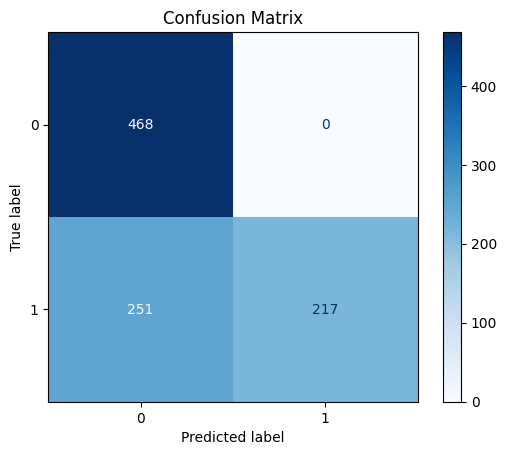

In [36]:
# Gerar a matriz de confusão
plot_confusion_matrix(y_test, y_pred)

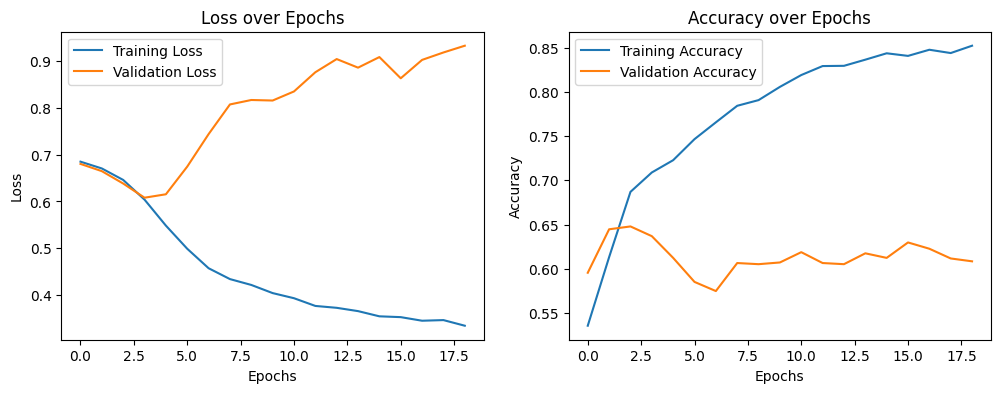

In [38]:
# Plotar o histórico do treinamento
plot_training_history(history)